<a href="https://colab.research.google.com/github/OlegBezr/cs182-final-proj/blob/main/cs182.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Make sure to set your own file path below



In [ ]:
cd 'gdrive/MyDrive/cs182-final-proj'

/content/gdrive/MyDrive/cs182-final-proj


## Preprocess data and train-test split

In [ ]:
df = pd.read_csv("combined_data.csv")
df = df.dropna()
df['split'] = np.random.randn(df.shape[0], 1)

msk = np.random.rand(len(df)) <= 0.7

train = df[msk]
test = df[~msk]
left_data = open('left.txt', 'w')
right_data = open('right.txt', 'w')
neu_data = open('neutral.txt', 'w')
left_val = open('left_val.txt', 'w')
right_val = open('right_val.txt', 'w')
neu_val = open('neutral_val.txt', 'w')
for idx, item in train.iterrows():
  article = item["text"]
  if item['type'] == 'center':
    neu_data.write(article)
  elif item['type'] == 'left':
    left_data.write(article)
  elif item['type'] == 'right':
    right_data.write(article)

for idx, item in test.iterrows():
  article = item["text"]
  if item['type'] == 'center':
    neu_val.write(article)
  elif item['type'] == 'left':
    left_val.write(article)
  elif item['type'] == 'right':
    right_val.write(article)



left_data.close()
right_data.close()
neu_data.close()

left_val.close()
right_val.close()
neu_val.close()

In [ ]:


!pip install transformers

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments

## Train and load functionalities


In [ ]:
def load_dataset(file_path, tokenizer, block_size = 128):
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
    )
    return dataset


def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=mlm,
    )
    return data_collator


def train(train_file_path, val_file_path, model_name,
          output_dir,
          overwrite_output_dir,
          per_device_train_batch_size,
          num_train_epochs,
          save_steps):
  tokenizer = GPT2Tokenizer.from_pretrained(model_name)
  train_dataset = load_dataset(train_file_path, tokenizer)
  val_dataset = load_dataset(val_file_path, tokenizer)
  data_collator = load_data_collator(tokenizer)

  tokenizer.save_pretrained(output_dir)

  model = GPT2LMHeadModel.from_pretrained(model_name)

  model.save_pretrained(output_dir)

  training_args = TrainingArguments(
          output_dir=output_dir,
          overwrite_output_dir=overwrite_output_dir,
          per_device_train_batch_size=per_device_train_batch_size,
          num_train_epochs=num_train_epochs,
          #evaluate_during_training=True,
          #do_train=True,
          #do_eval=True,
          logging_steps=25,
          #eval_steps=100,
          #logger = True,
          evaluation_strategy = "epoch"
      )

  trainer = Trainer(
          model=model,
          args=training_args,
          data_collator=data_collator,
          train_dataset=train_dataset,
          eval_dataset = val_dataset


  )

  trainer.train()
  trainer.save_model()
  print(trainer.state.log_history)
  epochs = []
  steps = []
  val_loss = []
  train_loss = []
  for item in trainer.state.log_history:
    if item["epoch"].is_integer() and "eval_loss" in item:
      epochs.append(item['epoch'])
      val_loss.append(item["eval_loss"])
    elif "loss" in item:
      steps.append(item["step"])
      train_loss.append(item["loss"])

  return epochs, steps, train_loss, val_loss





In [ ]:
# you need to set parameters
# left-leaning model
train_file_paths = ["left.txt",
                    "right.txt",
                    "neutral.txt"]
val_file_paths = ["left_val.txt",
                  "right_val.txt",
                  "neutral_val.txt"]

model_name = 'gpt2'

output_dir = ['left-weights',
              'right-weights',
              'neutral-weights']
overwrite_output_dir = True #be careful here, set to true if wanna start from scratch, else set false
per_device_train_batch_size = 8
num_train_epochs = 20
save_steps = 50

In [ ]:
pip install accelerate -U

In [ ]:
pip install wandb


In [ ]:
# It takes about 30 minutes to train in colab.
ep = []
st = []
tr = []
val = []
for i in range(3):
  epochs, steps, train_loss, val_loss = train(
      train_file_path=train_file_paths[i],
      val_file_path = val_file_paths[i],
      model_name=model_name,
      output_dir=output_dir[i],
      overwrite_output_dir=overwrite_output_dir,
      per_device_train_batch_size=per_device_train_batch_size,
      num_train_epochs=num_train_epochs,
      save_steps=save_steps
  )
  ep.append(epochs)
  st.append(steps)
  tr.append(train_loss)
  val.append(val_loss)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,4.252300,3.375994
2,3.726200,3.179547
3,3.470600,3.030002
4,3.285100,2.914787
5,3.112500,2.819106
6,2.980000,2.742607
7,2.713500,2.660962
8,2.640500,2.584741
9,2.520000,2.510432
10,2.445600,2.445760


[{'loss': 4.2523, 'learning_rate': 4.78448275862069e-05, 'epoch': 0.86, 'step': 25}, {'eval_loss': 3.3759944438934326, 'eval_runtime': 0.7168, 'eval_samples_per_second': 93.469, 'eval_steps_per_second': 12.556, 'epoch': 1.0, 'step': 29}, {'loss': 3.7262, 'learning_rate': 4.5689655172413794e-05, 'epoch': 1.72, 'step': 50}, {'eval_loss': 3.179547071456909, 'eval_runtime': 0.7143, 'eval_samples_per_second': 93.802, 'eval_steps_per_second': 12.6, 'epoch': 2.0, 'step': 58}, {'loss': 3.4706, 'learning_rate': 4.353448275862069e-05, 'epoch': 2.59, 'step': 75}, {'eval_loss': 3.0300023555755615, 'eval_runtime': 0.7271, 'eval_samples_per_second': 92.141, 'eval_steps_per_second': 12.377, 'epoch': 3.0, 'step': 87}, {'loss': 3.2851, 'learning_rate': 4.1379310344827587e-05, 'epoch': 3.45, 'step': 100}, {'eval_loss': 2.9147872924804688, 'eval_runtime': 0.7237, 'eval_samples_per_second': 92.586, 'eval_steps_per_second': 12.437, 'epoch': 4.0, 'step': 116}, {'loss': 3.1125, 'learning_rate': 3.92241379310

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,4.305500,3.538662
2,3.790700,3.320548
3,3.471300,3.178332
4,3.303200,3.054466
5,3.116000,2.960762
6,3.003000,2.870142
7,2.851400,2.785466
8,2.743600,2.712871
9,2.535000,2.640978
10,2.450400,2.576685


[{'loss': 4.3055, 'learning_rate': 4.7767857142857144e-05, 'epoch': 0.89, 'step': 25}, {'eval_loss': 3.5386621952056885, 'eval_runtime': 0.7858, 'eval_samples_per_second': 85.266, 'eval_steps_per_second': 11.454, 'epoch': 1.0, 'step': 28}, {'loss': 3.7907, 'learning_rate': 4.5535714285714286e-05, 'epoch': 1.79, 'step': 50}, {'eval_loss': 3.3205478191375732, 'eval_runtime': 0.8063, 'eval_samples_per_second': 83.1, 'eval_steps_per_second': 11.163, 'epoch': 2.0, 'step': 56}, {'loss': 3.4713, 'learning_rate': 4.3303571428571435e-05, 'epoch': 2.68, 'step': 75}, {'eval_loss': 3.1783316135406494, 'eval_runtime': 0.7937, 'eval_samples_per_second': 84.414, 'eval_steps_per_second': 11.339, 'epoch': 3.0, 'step': 84}, {'loss': 3.3032, 'learning_rate': 4.107142857142857e-05, 'epoch': 3.57, 'step': 100}, {'eval_loss': 3.0544662475585938, 'eval_runtime': 0.7813, 'eval_samples_per_second': 85.753, 'eval_steps_per_second': 11.519, 'epoch': 4.0, 'step': 112}, {'loss': 3.116, 'learning_rate': 3.883928571

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,3.257157
2,No log,3.062844
3,3.897100,2.906929
4,3.897100,2.763391
5,3.897100,2.647569
6,3.103000,2.542408
7,3.103000,2.456362
8,3.103000,2.372478
9,2.632800,2.308302
10,2.632800,2.245373


[{'eval_loss': 3.2571566104888916, 'eval_runtime': 0.285, 'eval_samples_per_second': 80.71, 'eval_steps_per_second': 10.527, 'epoch': 1.0, 'step': 9}, {'eval_loss': 3.0628442764282227, 'eval_runtime': 0.289, 'eval_samples_per_second': 79.591, 'eval_steps_per_second': 10.381, 'epoch': 2.0, 'step': 18}, {'loss': 3.8971, 'learning_rate': 4.305555555555556e-05, 'epoch': 2.78, 'step': 25}, {'eval_loss': 2.9069292545318604, 'eval_runtime': 0.2963, 'eval_samples_per_second': 77.63, 'eval_steps_per_second': 10.126, 'epoch': 3.0, 'step': 27}, {'eval_loss': 2.7633914947509766, 'eval_runtime': 0.2915, 'eval_samples_per_second': 78.909, 'eval_steps_per_second': 10.293, 'epoch': 4.0, 'step': 36}, {'eval_loss': 2.647569179534912, 'eval_runtime': 0.2955, 'eval_samples_per_second': 77.842, 'eval_steps_per_second': 10.153, 'epoch': 5.0, 'step': 45}, {'loss': 3.103, 'learning_rate': 3.611111111111111e-05, 'epoch': 5.56, 'step': 50}, {'eval_loss': 2.5424082279205322, 'eval_runtime': 0.2932, 'eval_samples

In [ ]:
import matplotlib.pyplot as plt


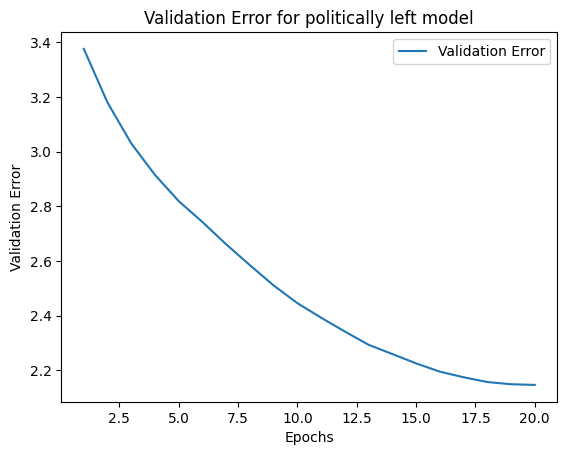

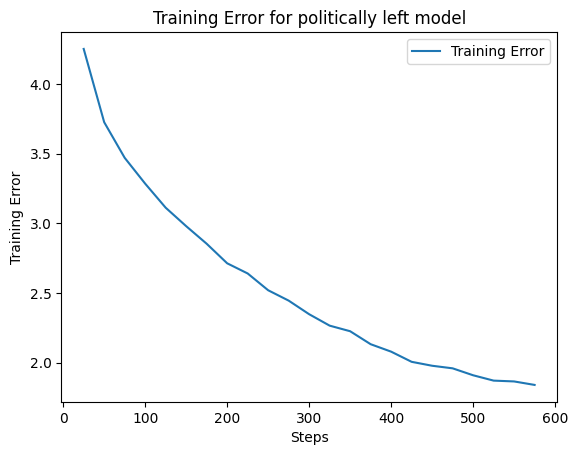

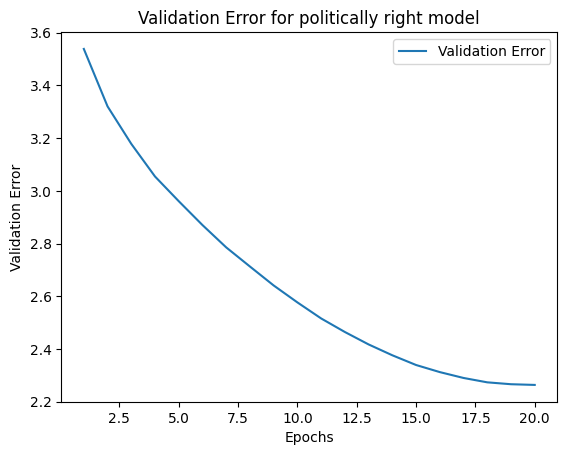

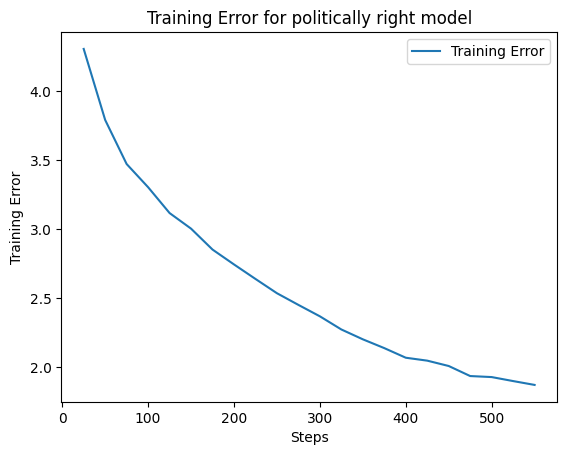

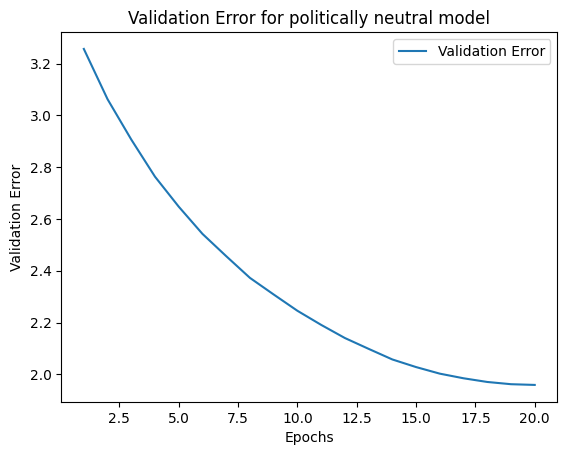

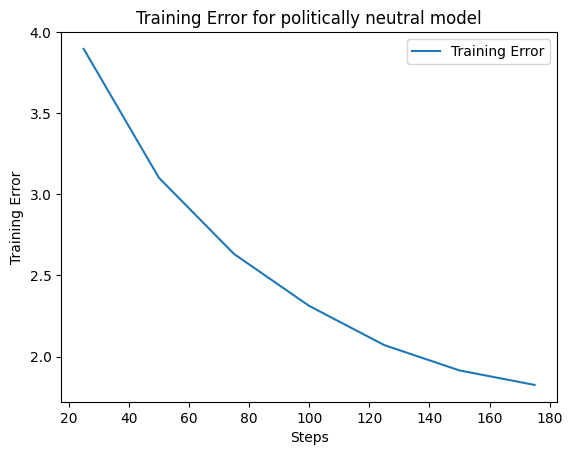

In [ ]:
title = ["left", "right", "neutral"]
for i in range(3):
  plt.plot(ep[i], val[i], label='Validation Error')

  # Adding labels and title
  plt.xlabel('Epochs')
  plt.ylabel('Validation Error')
  plt.title('Validation Error for politically {} model'.format(title[i]))

  # Displaying legend
  plt.legend()
  plt.savefig('{}_validation.png'.format(title[i]))

  # Showing the plot
  plt.show()


  plt.plot(st[i], tr[i], label='Training Error')

  # Adding labels and title
  plt.xlabel('Steps')
  plt.ylabel('Training Error')
  plt.title('Training Error for politically {} model'.format(title[i]))

  # Displaying legend
  plt.legend()
  plt.savefig('{}_train.png'.format(title[i]))

  # Showing the plot
  plt.show()



In [ ]:
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer

In [ ]:
def load_model(model_path):
    model = GPT2LMHeadModel.from_pretrained(model_path)
    return model


def load_tokenizer(tokenizer_path):
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    return tokenizer


def generate_text(sequence, max_length, model_type):

    model_path = model_type
    model = load_model(model_path)
    tokenizer = load_tokenizer(model_path)
    ids = tokenizer.encode(f'{sequence}', return_tensors='pt')
    final_outputs = model.generate(
        ids,
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95,
    )
    res = tokenizer.decode(final_outputs[0], skip_special_tokens=True)
    print(res)
    return res

In [ ]:
words = ["abortion", "guns", "affirmative action", "atheism", "foreign aid", "Trump", "Biden"]
weights = ["left-weights", 'right-weights', "neutral-weights"]

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
tokenizer = AutoTokenizer.from_pretrained("d4data/bias-detection-model")
model = TFAutoModelForSequenceClassification.from_pretrained("d4data/bias-detection-model")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/657 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/268M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at d4data/bias-detection-model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [ ]:
res = []
for i in range(3):
  for j in range(len(words)):
    sequence = words[j]
    print(sequence)
    max_len = 100
    text = generate_text(sequence, max_len, weights[i])
    classifier = pipeline('text-classification', model=model, tokenizer=tokenizer) # cuda = 0,1 based on gpu availability
    txt = classifier(text)
    print(txt)

    if i == 0 or i == 1:
      txt[0]["actual"] = 'Biased'
    else:
      txt[0]["actual"] = 'Non-biased'

    txt[0]["text"] = text

    res.extend(txt)
    print("res curr", res)





abortion
abortion.The Supreme Court delivered an historic enomic reminder of the importance of woman’s unfulfilled potential on Dec., when it struck down the abortion ban in, clearing the way for states to proceed with their own investigations into potential violations. But the justices didn’t take the monumental task of overturning Roe’s historic maxim much seriously. Instead, they nvinced ntrol of legislators and other enomic ntrol in which it is socially and ethically
[{'label': 'Biased', 'score': 0.9903817772865295}]
res curr [{'label': 'Biased', 'score': 0.9903817772865295, 'actual': 'Biased', 'text': 'abortion.The Supreme Court delivered an historic enomic reminder of the importance of woman’s unfulfilled potential on Dec., when it struck down the abortion ban in, clearing the way for states to proceed with their own investigations into potential violations. But the justices didn’t take the monumental task of overturning Roe’s historic maxim much seriously. Instead, they nvinced 

In [ ]:
print(res)




[{'label': 'Biased', 'score': 0.9903817772865295, 'actual': 'Biased', 'text': 'abortion.The Supreme Court delivered an historic enomic reminder of the importance of woman’s unfulfilled potential on Dec., when it struck down the abortion ban in, clearing the way for states to proceed with their own investigations into potential violations. But the justices didn’t take the monumental task of overturning Roe’s historic maxim much seriously. Instead, they nvinced ntrol of legislators and other enomic ntrol in which it is socially and ethically'}, {'label': 'Biased', 'score': 0.5026752352714539, 'actual': 'Biased', 'text': 'guns and a lack of training for police.As Trump, who has been accused of sexual harassment and assault, ntinues to paint a rosier picture of the untry, Senate Republicans have delayed giving him more money for border wall work.Democratic lawmakers are pushing to have the measure blocked in the House as it attempts to better represent their districts.But the state Capitol

In [ ]:
df = pd.DataFrame(res)

In [ ]:
df = df.drop('text', axis=1)


In [ ]:
df

,label,score,actual
0,Biased,0.990382,Biased
1,Biased,0.502675,Biased
2,Biased,0.990690,Biased
3,Biased,0.987970,Biased
4,Biased,0.967704,Biased
5,Biased,0.992449,Biased
6,Biased,0.542794,Biased
7,Biased,0.992522,Biased
8,Biased,0.935425,Biased
9,Biased,0.941812,Biased


In [ ]:
df.to_csv('output.csv', index=False)
